In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
import pickle
np.set_printoptions(linewidth = 200)

In [2]:
class MLP:

    def __init__(self, num_inputs=3, hidden_layers =[2], num_outputs=2):

        # Initiate array of layers size
        self.num_inputs = num_inputs
        self.hidden_layers = hidden_layers
        self.num_outputs = num_outputs

        # create a generic representation of the layers
        layers = [num_inputs] + hidden_layers + [num_outputs]

        # create random connection weights for the layers
        self.weights = [(np.random.uniform(low = -0.5, high = 0.5, size = (layers[i] + 1, layers[i + 1]))) for i in range(len(layers) - 1)]

        # save derivatives per layer
        self.derivatives = [np.zeros((layers[i] + 1, layers[i + 1])) for i in range(len(layers) - 1)]

        # save activations per layer

        #print(layers)
        #self.activations = [np.zeros(layers[i] + 1) if i!= len(layers)-1 else np.zeros(layers[i]) for i in range(len(layers))]
        self.activations = [np.zeros(layers[i] + 1) for i in range(len(layers))]

    
    def back_propagate(self, error, debug = False):

        for i in reversed(range(len(self.derivatives))):
            # If w2, take derivative of a3
            # define delta as: dE/da_(i+1) * s'(a_i+1)
            if i == len(self.derivatives) - 1:
                #print('here')
                delta = error
            else:
                delta = error * self._sigmoid_derivative(self.activations[i+1][:-1])

            # Converts delta from array [0.1, 0.2] to 1x2 matrix [[0.1, 0.2]]
            delta_reshaped = delta.reshape(delta.shape[0],-1).T

            # get activations for current layer
            #current_activations = self.activations[i]

            # Converts a_i from array [0.1, 0.2] to 2x1 matrix [[0.1], [0.2]]
            current_activations = self.activations[i].reshape(self.activations[i].shape[0], -1)

            # Get the matrix of derivatives for W_i
            self.derivatives[i] = np.dot(current_activations, delta_reshaped)

            # error for prev layer as: dE/da_(i+1) * s'(a_i+1) * W_i or delta * W_i
            error = np.dot(delta, self.weights[i][:-1].T)

            if debug:
                print(f"Derivatives for W{i}: {self.derivatives[i]}")

    def forward_propagate(self, inputs):

        # Store the input layer activations
        activations = inputs
        self.activations[0][:-1] = activations
        self.activations[0][-1] = 1
        activations = np.append(activations, 1)

        #print(self.activations)

        for i, w in enumerate(self.weights):
            # Calculate inputs h
            #print(activations, i)
            net_inputs = np.dot(activations, w)

            # Calculate the activations
            if i != len(self.weights) - 1:
                activations = self._sigmoid(net_inputs)
            else:
                activations = net_inputs

            # Save the activation for the current layer (if weights at W1, store a2)
            self.activations[i+1][:-1] = activations
            self.activations[i+1][-1] = 1
            activations = np.append(activations, 1)

        predictions = self._softmax(self.activations[-1][:-1])
    
        return predictions


    def gradient_descent(self, learning_rate, debug = False):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.derivatives[i]


    def train(self, inputs, targets, epochs = 10, learning_rate = 0.1, batch_size = 0):

        for i in range(epochs):
            sum_error = 0
            for j in range(len(inputs)):

                # Forward propagate
                output = self.forward_propagate(inputs[j])

                # Find derivative of loss function with respect to output layer
                loss_derivative = output - targets[j]

                # Back propagate to find the derivatives
                self.back_propagate(loss_derivative)

                # Gradient descent to update weights
                self.gradient_descent(learning_rate)

                # Calculate the error at this iteration
                sum_error += self._mse(targets[j], output)
            
            # report error
            print(f"Epoch {i+1}, Mean Squared Error: {sum_error/len(inputs)}")

    @staticmethod
    def _softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    @staticmethod
    def _softmax_derivative(x):
        s = x.reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)

    @staticmethod
    def _mse(target, output):
        return np.average((target - output) ** 2)

    @staticmethod
    def _sigmoid_derivative(x):
        return x * (1.0 - x)

    @staticmethod
    def _sigmoid(x):
        return 1.0 / (1 + np.exp(-x))

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train_normalized = (x_train) / 255.0
x_test_normalized = (x_test) / 255.0

flattenedX = np.array([np.zeros(784) for _ in range(60000)])
for i in range(len(x_train)):
    flattenedX[i] = x_train_normalized[i].flatten()

one_hot_y = np.array([np.zeros(10) for _ in range(60000)])
for i in range(len(x_train)):
    one_hot_y[i][y_train[i]] = 1

flattenedTest = np.array([np.zeros(784) for _ in range(10000)])
for i in range(len(flattenedTest)):
    flattenedTest[i] = x_test_normalized[i].flatten()

In [4]:
with open('mlp_data.pkl', 'rb') as input:
    mlp = pickle.load(input)

ValueError: could not broadcast input array from shape (784) into shape (783)

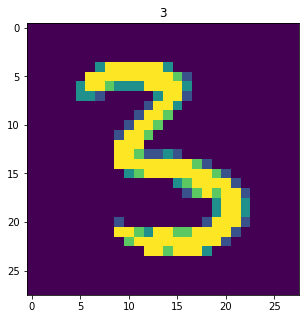

In [6]:
index = 2151

plt.figure(figsize=(5,5))
plt.imshow(x_test_normalized[index])
plt.title(y_test[index])

output = mlp.forward_propagate(flattenedTest[index])
prediction = np.argmax(output)
probability = output[prediction]

print(f"Prediction: {prediction}, probability: {probability * 100}%")